In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date

spark = SparkSession.builder.appName("FileFormatsDemo").getOrCreate()

data = [
    (1, "Alice", "US", 100, "2024-01-01"),
    (2, "Bob", "EU", 200, "2024-01-02"),
    (3, "Charlie", "US", 150, "2024-01-03")
]

columns = ["order_id", "customer", "region", "amount", "order_date"]

df = spark.createDataFrame(data, columns) \
          .withColumn("order_date", to_date("order_date"))

df.show()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/16 17:16:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/16 17:16:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/16 17:16:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/16 17:16:03 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
                                                                                

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
|       3| Charlie|    US|   150|2024-01-03|
+--------+--------+------+------+----------+



In [2]:
df.printSchema()

root
 |-- order_id: long (nullable = true)
 |-- customer: string (nullable = true)
 |-- region: string (nullable = true)
 |-- amount: long (nullable = true)
 |-- order_date: date (nullable = true)



Read/write options

Read operation (from disk → RAM)

A read operation loads data from disk (HDFS / S3 / local disk / DB) into RAM as a DataFrame.


Write operation (RAM → disk)

A write operation saves the DataFrame from RAM to disk.

header=true → first row has column names

inferSchema=true → Spark guesses data types (slow & risky)

In [3]:
csv_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/data/employee.csv")

csv_df.show()


+---+-------+---+-----------+------+
| id|   name|age| department|salary|
+---+-------+---+-----------+------+
|  1|  Alice| 24|Engineering| 70000|
|  2|    Bob| 30|  Marketing| 60000|
|  3|Charlie| 28|      Sales| 55000|
|  4|  David| 35|Engineering| 90000|
|  5|    Eva| 26|         HR| 50000|
|  6|  Frank| 40|    Finance| 95000|
|  7|  Grace| 29|  Marketing| 62000|
|  8|  Helen| 32|         HR| 58000|
|  9|    Ian| 27|      Sales| 54000|
| 10|   Jack| 45| Management|120000|
+---+-------+---+-----------+------+



In [5]:
csv_df = spark.read.csv("/data/employee.csv")
csv_df.show()

+---+-------+---+-----------+------+
|_c0|    _c1|_c2|        _c3|   _c4|
+---+-------+---+-----------+------+
| id|   name|age| department|salary|
|  1|  Alice| 24|Engineering| 70000|
|  2|    Bob| 30|  Marketing| 60000|
|  3|Charlie| 28|      Sales| 55000|
|  4|  David| 35|Engineering| 90000|
|  5|    Eva| 26|         HR| 50000|
|  6|  Frank| 40|    Finance| 95000|
|  7|  Grace| 29|  Marketing| 62000|
|  8|  Helen| 32|         HR| 58000|
|  9|    Ian| 27|      Sales| 54000|
| 10|   Jack| 45| Management|120000|
+---+-------+---+-----------+------+




# Scenario

* File is stored on **local disk**
* You are using **PySpark**
* You perform:

  1. `spark.read(...)`
  2. `df.show()`
  3. `df.write(...)`

---

## 1️⃣ File exists on LOCAL DISK (before Spark starts)

At this stage:

* File is **permanent**
* Stored on disk (e.g., CSV/Parquet/JSON)
* Spark has **not touched the data yet**

```
Local Disk
└── data.csv
```

Nothing is in RAM.

---

## 2️⃣ `spark.read(...)` — LOGICAL READ (Lazy Execution)

```python
df = spark.read.csv("data.csv", header=True)
```

### What ACTUALLY happens:

❗ **No data is read yet**

Spark only:

* Creates a **logical plan**
* Stores **metadata**:

  * File path
  * Schema
  * Format
* Creates a **DataFrame reference**

### Internally:

* Driver builds a **logical DAG**
* No executors involved
* No RAM usage for actual data

```
Driver:
Logical Plan → “Read CSV from data.csv”
```

📌 **Key point:**

> `spark.read()` does NOT load data immediately (lazy evaluation).

---

## 3️⃣ Micro-Partitions (How Spark plans the read)

Even before reading:

* Spark **plans** how data *will be split*
* File is divided into **partitions (micro-partitions)**

### How partitioning works:

* Based on:

  * File size
  * `spark.sql.files.maxPartitionBytes` (default ~128MB)
* Example:

  * 1 GB file → ~8 partitions
  * Each partition = **task unit**

```
data.csv
├── Partition 1
├── Partition 2
├── Partition 3
└── Partition 4
```

⚠️ Still **not loaded** — only planned.

---

## 4️⃣ `df.show()` — ACTION (Triggers Execution)

```python
df.show()
```

This is the **most important step**.

### What happens now (background steps):

#### A. Action triggers execution

* `show()` is an **action**
* Spark now executes the DAG

#### B. Driver → Executors

* Driver sends tasks to executors
* Each executor handles one or more partitions

#### C. Actual READ happens here

For each partition:

* Data is read from **local disk**
* Loaded into **executor memory (RAM)**
* Parsed (CSV → internal Spark format)
* Converted to **UnsafeRow / Tungsten format**

```
Local Disk → Executor RAM
```

#### D. `show()` behavior

* Spark reads **only required rows** (default 20)
* Not the entire dataset
* Stops once enough rows are collected

```
Executor → Driver → Console Output
```

📌 **Important:**

> Data is **temporarily in RAM**, not saved anywhere.

---

## 5️⃣ After `show()` finishes

* Executor memory is **released**
* DataFrame still exists as a **logical object**
* Data is **not cached** unless explicitly told

If session ends now:
❌ DataFrame is gone
❌ RAM is cleared
✅ File still exists on disk

---

## 6️⃣ Optional: Cache / Persist (Still NOT permanent)

```python
df.cache()
df.show()
```

Now:

* Data is stored in **executor RAM**
* Reused across actions
* Still **session-bound**

❌ Lost when session ends
❌ Not written to disk (unless MEMORY_AND_DISK)

---

## 7️⃣ `df.write(...)` — WRITE ACTION (RAM → DISK)

```python
df.write.mode("overwrite").parquet("output_path")
```

### Background steps:

#### A. Action triggers execution again

* Full dataset is read
* All partitions processed

#### B. Each partition writes separately

* Each executor writes **one output file per partition**

```
Executor 1 → part-0000.parquet
Executor 2 → part-0001.parquet
Executor 3 → part-0002.parquet
```

#### C. Data flow

```
Local Disk (input)
→ Executor RAM
→ Local Disk (output)
```

### Result:

* Output files stored on disk
* Data is now **permanent**

---

## 8️⃣ Session Ends

When Spark session stops:

* Executor memory cleared
* Driver memory cleared
* All DataFrames destroyed

But:
✅ Written data remains on disk

---

## 9️⃣ Next Session (Read Again)

```python
df2 = spark.read.parquet("output_path")
```

* New logical plan
* New partitions
* New read from disk
* Old DataFrame does not exist

---

## 🔁 Full Lifecycle Summary

```
[Disk File]
    ↓ spark.read (lazy)
[Logical Plan]
    ↓ show() / write() (action)
[Partitions Created]
    ↓
[Executors Read Data into RAM]
    ↓
[show()] → display only
[write()] → save to disk
```

---

## 🔑 Key Corrections to Your Original Thought

✔ **Correct**

* DataFrame exists only in session
* Read must be re-executed each session
* Write makes data permanent

❌ **Incorrect**

* `show()` does NOT store or reflect data
* `show()` does NOT write
* `show()` does NOT persist

---

## One-Line Rule (Very Important)

> **Read defines WHERE data comes from,
> Actions trigger WHEN data is read,
> Write defines WHERE data is saved permanently.**

---


In [6]:
json_df = spark.read \
    .option("multiLine", "false") \
    .json("/data/employee.json")

json_df.show()


+---+-----------+---+-------+------+
|age| department| id|   name|salary|
+---+-----------+---+-------+------+
| 24|Engineering|  1|  Alice| 70000|
| 30|  Marketing|  2|    Bob| 60000|
| 28|      Sales|  3|Charlie| 55000|
| 35|Engineering|  4|  David| 90000|
| 26|         HR|  5|    Eva| 50000|
| 40|    Finance|  6|  Frank| 95000|
| 29|  Marketing|  7|  Grace| 62000|
| 32|         HR|  8|  Helen| 58000|
| 27|      Sales|  9|    Ian| 54000|
| 45| Management| 10|   Jack|120000|
+---+-----------+---+-------+------+



multiLine = false (default)

One line = one row

In [7]:
df.write \
  .mode("overwrite") \
  .json("/data/employee.json")


In [8]:
parquet_df = spark.read.parquet("/data/employees.parquet")
parquet_df.show()


+---+-------+---+-----------+------+
| id|   name|age| department|salary|
+---+-------+---+-----------+------+
|  1|  Alice| 24|Engineering| 70000|
|  4|  David| 35|Engineering| 90000|
|  7|  Grace| 29|  Marketing| 62000|
| 10|   Jack| 45| Management|120000|
|  3|Charlie| 28|      Sales| 55000|
|  6|  Frank| 40|    Finance| 95000|
|  2|    Bob| 30|  Marketing| 60000|
|  9|    Ian| 27|      Sales| 54000|
|  8|  Helen| 32|         HR| 58000|
|  5|    Eva| 26|         HR| 50000|
+---+-------+---+-----------+------+



In [9]:
df.write \
  .mode("overwrite") \
  .parquet("/data/employees.parquet")


In [10]:
df.show()

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
|       3| Charlie|    US|   150|2024-01-03|
+--------+--------+------+------+----------+



In [ ]:
Append (add new data)

In [ ]:
## 1️⃣ Adding rows to DataFrame in RAM (union) ❌

**Layman analogy:**
Imagine you have a **whiteboard** with a list of names:

```
Whiteboard:
Alice
Bob
```

You want to add **Charlie**. But instead of writing on the same board, you take a **new whiteboard**, copy the old names, and add Charlie:

```
New Whiteboard:
Alice
Bob
Charlie
```

* The **old board (original DataFrame)** is untouched.
* This only exists **in your classroom (RAM)**.
* If you leave the room (program ends), the board disappears.

**Python/Spark analogy:**

```python
# Original data
df1 = [("Alice", 25), ("Bob", 30)]

# New data
df2 = [("Charlie", 28)]

# Combine (union)
df3 = df1 + df2  # New DataFrame
```

* `df1` → still just Alice and Bob
* `df3` → Alice, Bob, Charlie
* Nothing is written to disk.

---

## 2️⃣ Writing new data to existing files ✅

**Layman analogy:**
Instead of using a whiteboard, you have a **notebook** (file on disk).

```
Notebook.txt:
Alice
Bob
```

You add Charlie by **writing into the notebook**. Now if you leave the room, the notebook still has **Alice, Bob, Charlie**.

* This is **persistent**, it doesn’t disappear when the program stops.

**Python/Spark analogy:**

```python

---

## 🔑 Key takeaway in layman terms

| Action              | Analogy                                                        | Persistence                                 |
| ------------------- | -------------------------------------------------------------- | ------------------------------------------- |
| **Union in RAM**    | Copying old whiteboard to a new whiteboard and adding new info | ❌ disappears when you leave (program stops) |
| **Writing to file** | Writing directly in your notebook                              | ✅ stays forever                             |

---



Exactly — you’ve hit on a subtle but important point in Spark (and similar systems):

**Append only works at write-time, not read-time.**

Let me break it down clearly.

---

## 1️⃣ What “append mode” means

When you do something like:

```python
df.write.mode("append").parquet("/data/users")
```

* Spark **writes new rows to the existing files** (or adds new files in the folder).
* It **does not modify or merge the existing files**.
* The **append happens only when writing**.

**Important:** Nothing magically appears in your DataFrame when you read the files — the append affects storage, not your in-memory copy.

---

## 2️⃣ What happens at read-time

```python
df_read = spark.read.parquet("/data/users")
```

* Spark **reads whatever exists on disk at that moment**.
* If you later append more data:

```python
df_new = spark.createDataFrame([("David", 40)])
df_new.write.mode("append").parquet("/data/users")
```

* You **must read the files again** to see David.
* Existing in-memory DataFrames don’t auto-update.

**Key takeaway:** append is **write-time behavior only**. Reading is always **snapshot-based**.

---


```python
# Initial write
df1 = spark.createDataFrame([("Alice", 25)])
df1.write.mode("overwrite").parquet("/data/users")

# Append new data
df2 = spark.createDataFrame([("Bob", 30)])
df2.write.mode("append").parquet("/data/users")

# Read data (snapshot at this moment)
df_all = spark.read.parquet("/data/users")
df_all.show()
```

**Output:**

```
Alice, 25
Bob, 30
```



In [11]:
df.show()

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
|       3| Charlie|    US|   150|2024-01-03|
+--------+--------+------+------+----------+



In [13]:
#df.read.employee.csv.show()
df_csv = spark.read.option("header", True).csv("/data/employee.csv")
df_csv.show()

+---+-------+---+-----------+------+
| id|   name|age| department|salary|
+---+-------+---+-----------+------+
|  1|  Alice| 24|Engineering| 70000|
|  2|    Bob| 30|  Marketing| 60000|
|  3|Charlie| 28|      Sales| 55000|
|  4|  David| 35|Engineering| 90000|
|  5|    Eva| 26|         HR| 50000|
|  6|  Frank| 40|    Finance| 95000|
|  7|  Grace| 29|  Marketing| 62000|
|  8|  Helen| 32|         HR| 58000|
|  9|    Ian| 27|      Sales| 54000|
| 10|   Jack| 45| Management|120000|
+---+-------+---+-----------+------+



In [14]:
# Path to CSV folder
csv_path = "/data/orders_csv"

# Append DataFrame to existing CSV
df.write \
  .option("header", "true") \
  .mode("append") \
  .csv(csv_path)


In [15]:
#df.read.employee.csv.show()
df_csv = spark.read.option("header", True).csv("/data/orders_csv")
df_csv.show()

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       3| Charlie|    US|   150|2024-01-03|
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+



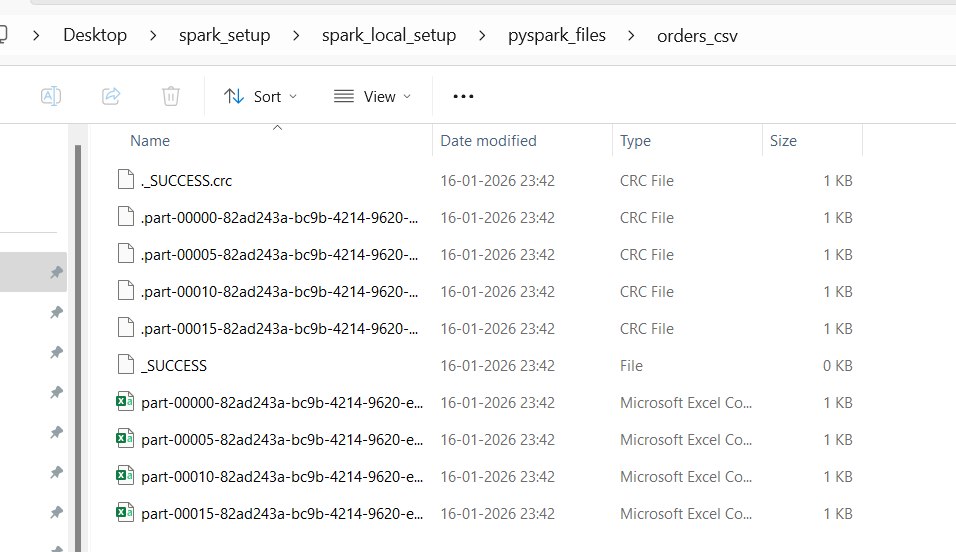

In [19]:
# Path to JSON folder
json_path = "/data/orders_json"

# Append DataFrame to JSON
df.write \
  .mode("append") \
  .json(json_path)


In [21]:
#df.read.employee.csv.show()
df_all = spark.read.json(json_path)
df_all.show()


+------+--------+----------+--------+------+
|amount|customer|order_date|order_id|region|
+------+--------+----------+--------+------+
|   150| Charlie|2024-01-03|       3|    US|
|   150| Charlie|2024-01-03|       3|    US|
|   100|   Alice|2024-01-01|       1|    US|
|   100|   Alice|2024-01-01|       1|    US|
|   200|     Bob|2024-01-02|       2|    EU|
|   200|     Bob|2024-01-02|       2|    EU|
+------+--------+----------+--------+------+



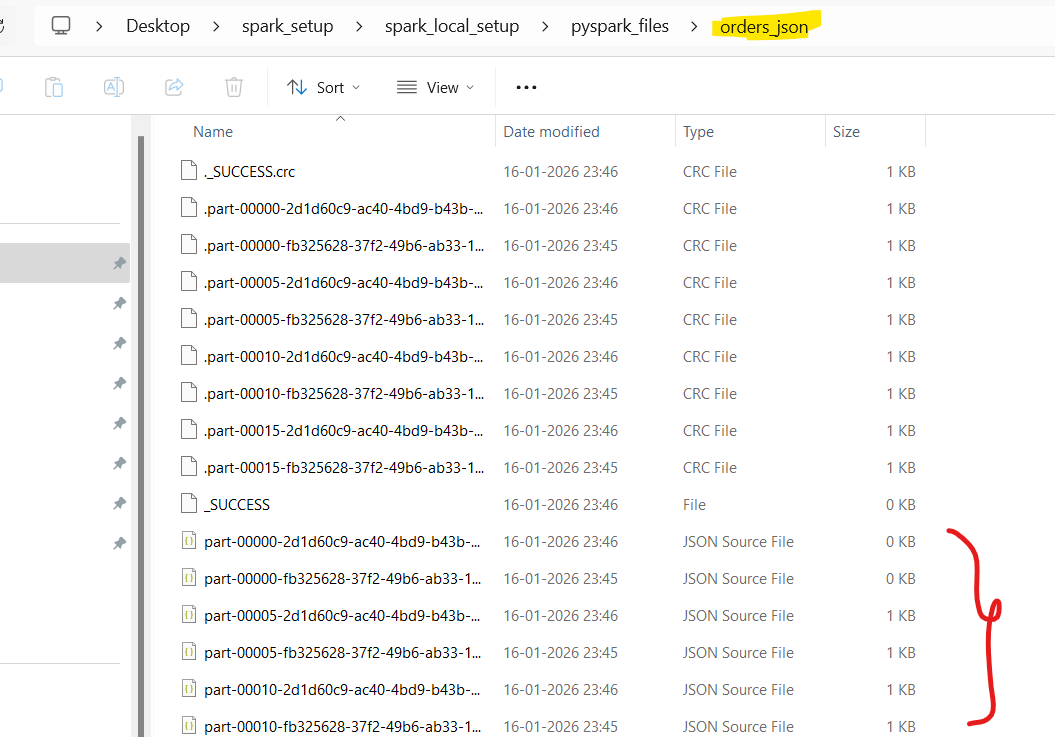

In [23]:
df.write \
  .mode("append") \
  .parquet("/data/orders_parquet")


In [24]:
df_all = spark.read.parquet("/data/orders_parquet")
df_all.show()


+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       3| Charlie|    US|   150|2024-01-03|
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+



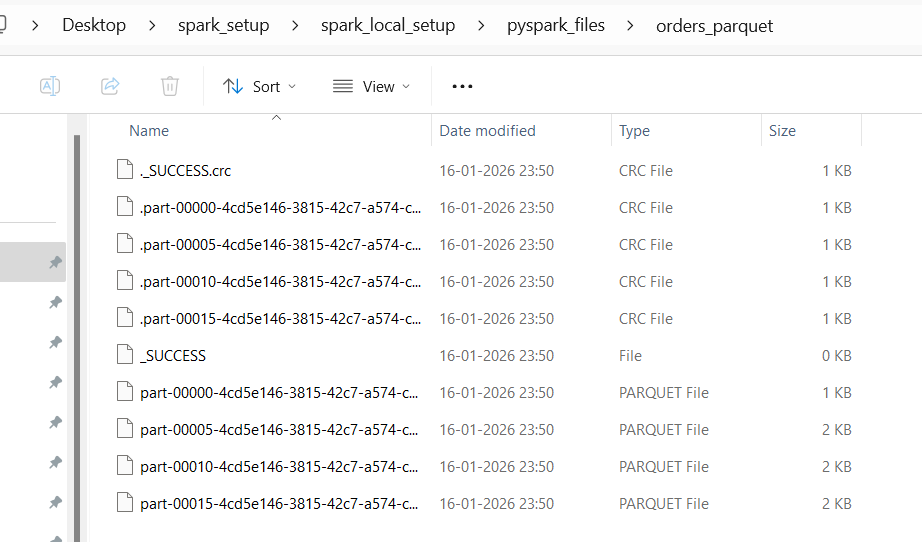

Write Modes (Append, Overwrite, Ignore)
Append (add new data)
df.write \
  .mode("append") \
  .parquet("/data/orders_parquet")

Overwrite (replace existing data)
df.write \
  .mode("overwrite") \
  .parquet("/data/orders_parquet")

Ignore (do nothing if data exists)
df.write \
  .mode("ignore") \
  .parquet("/data/orders_parquet")